In [1]:
# This runs on CIT, it would need to be 
# modified to run elsewhere designed only as a test (Could be used for Review)
# This notebook reproduces the 170817 analysis done by the LVK using our inference pipeline
# We will not want to use spectral samples in O4 because of correlations + also there 
# are other pipelines that do this (bilby w/ eos)

%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import bilby.gw.conversion as conversion
import matplotlib.pyplot as plt
import copy
from  scipy.special import logsumexp, rel_entr
import seaborn as sns

import lwp
import lwp.executables.get_files as get_files

from lwp import executables

# Some utilities needed for weighted stats
def mean(quantity, weights):
    probability = weights/np.sum(weights)
    return np.sum(quantity*probability)
def std_deviation(quantity, weights):
    q_mean = mean(quantity, weights)
    deviation = (quantity-q_mean)
    return np.sqrt(mean(deviation**2, weights))

# Evaluating the KDE

One of the review tasks we decided was important was checking the KDE, we do this by simulating a likelihood and demonstrating we can recover a posterior by weighing prior samples.  Consider 
$$\pi(x) = \text{Uniform}(-2, 2) \times \text{Uniform}(-2,2)$$
$$\mathcal{L}(x)\propto\exp\left(-\frac{1}{2} x^T C^{-1} x\right)$$
with 
$$C = \begin{pmatrix}1&0 \\0&1\end{pmatrix}$$
The posterior is proportional to
$$P(x) \propto \pi(x)\mathcal{L}(x)$$

In [7]:
# We can implement this in lwp and evaluate the performance of the kde 
# at modeling the likelihood.  We first build the likelihood from prior 
# samples
seed = 12345
rng = np.random.default_rng(seed=seed) # random number generator
# sample from a distribution proportional to the likelihood.
likelihood_cov = np.array([[1,0],[0,1]])
likelihood_mean = np.array([0,0])
likelihood_samples = rng.multivariate_normal(mean=likelihood_mean, 
                                  cov=likelihood_cov, size=1000)


In [8]:
likelihood_dataframe = pd.DataFrame(likelihood_samples, columns = ["x1","x2"])
samples_prefix=f"likelihood_example_samples_{seed}"
samples_outpath = f"{samples_prefix}.csv"
likelihood_dataframe.to_csv(samples_outpath, index=False)

In [ ]:
# We now need to compute the optimal bandwidth for the samples we've drawn
executables.scan_likelihood([samples_outpath], cols=["x1", "x2"],
                            bwrng=[0.01, 0.6]) # designed to operate on a list



In [ ]:
samples_in_file = f"{samples_prefix}.in" 
samples_in_data = pd.read_csv(samples_in_file)
samples_in_data

In [ ]:
# Get the optimal kde bandwidth from the file
bw = samples_in_data["bw"][0]

# Prior Samples
We now want to generate prior samples to weigh
by the likelihood

In [11]:
prior_samples = rng.uniform(-2.0, 2.0, (1000,2))

In [12]:
prior_dataframe = pd.DataFrame(prior_samples, columns=["x1", "x2"])

# Weighing the samples

We now weigh the prior samples by the likelihood

In [13]:
weighed_samples = executables.weigh_samples(likelihood_dataframe, 
                                            prior_dataframe, output=None,
                                           bandwidth=bw, columns=["x1", "x2"],
                                           prior_columns=[], prior_name=None, 
                                            save_samples=False, reflect=True)

In [14]:
weighed_samples

x1        x2  logweight
0    0.997771  0.309188   4.444304
1   -1.558140  0.820331   3.426862
2    1.234565 -0.177379   4.184347
3   -0.380058  1.052013   4.398693
4    0.776886 -1.000076   4.130244
..        ...       ...        ...
995  1.149380 -0.310589   4.224469
996  1.472595  0.148856   3.958073
997 -0.347290  1.281783   4.210995
998 -0.403039 -1.379046   3.986520
999  1.540916 -1.051933   3.405826

[1000 rows x 3 columns]

# Comparing to an analytic solution
In order for the kde to be effective, the variation in the weights induced by using the kde (compared to the analytic solution) should be small.  We first normalize the weights so that they represent posterior probabilities. since we have flat priors.
$$\log P = \log(\mathrm{weight}) - \log\left(\sum{\mathrm{weights}}\right) $$
We denote with $P$ the posterior induced by using the KDE, and $P_0$ the the true posterior. We would like the quantity $$\Delta \log P(x) \equiv \log P(x) - \log P_0(x)$$ to not be large, or at least not be large where the posterior has support. 
One way to measure this is with the K-L divergence
$$D_{\mathrm{KL}}(P, P_0)=\int P(x)\log\left(\frac{P_{0}(x)}{P(x)}\right)dx$$ 

In [15]:
# Analytic solution for this likelihood
def log_likelihood(x, likelihood_mean, likelihood_cov):
    x = np.transpose(np.matrix(np.array([x])))
    return -1/2*np.transpose(x)*np.linalg.inv(np.matrix(likelihood_cov))*x

In [16]:
log_likelihood([[0,1]], likelihood_mean, likelihood_cov)

matrix([[-0.5]])

In [17]:
# Compute the predicted weight of all the samples
weights = np.zeros(weighed_samples.shape[0])
for i, weight in enumerate(weights):
    weights[i] = log_likelihood(np.array(weighed_samples[["x1","x2"]])[i,:], likelihood_mean, likelihood_cov)[0,0]

KL divergence is:  0.009673931161078423


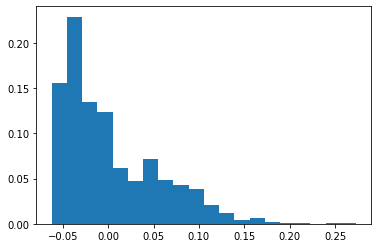

In [18]:
# compute the KL divergence between the two distributions
logp_kde =  weighed_samples["logweight"]- logsumexp(weighed_samples["logweight"])
logp_true = weights - logsumexp(weights)
kl_values = rel_entr(np.exp(logp_kde), np.exp(logp_true))
print("KL divergence is: ", np.sum(kl_values))


In general, statistical fluctuations can shift the means of the likelihood distribution by of order one standard deviation, which can lead to changes in logweights downstream of order 
$$\sqrt{\mathcal O(1) + |\log P|}$$
It is always possible to use more samples to more finely resolve the likelihood, but typically once changes are much than this, then they do not correspond to additional physical information.  Once more, Monte Carlo sampling is generally extremely slow to converge, so achieving higher precision comes with a significant tradeoff of computation time.  In the case of this particular problem, the errors we see are typically less than $1/10$  the threshold value set above even for the case of $\sim 1000$ likelihood samples

Text(0, 0.5, 'probability')

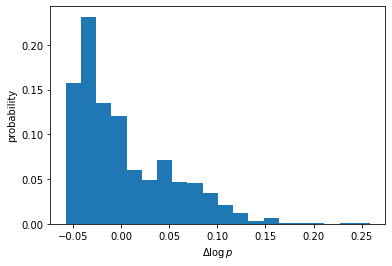

In [26]:
# We plot  Delta(logp) / sqrt(1+ abs log(p))
# The errors are typically no worse than 1/10 the threshold
plt.hist((logp_kde - logp_true)/np.sqrt(1-logp_kde), bins=20, weights=np.exp(logp_kde))
plt.xlabel(r"$\Delta \log p$")
plt.ylabel("probability")

# A sharper likelihood and more samples
In general our likelihood will be contained entirely inside the prior, 
so a better test case is one with a more sharply contained likelihood.  
This will induce a smaller bandwidth, and therefore for comparable prior support
will require more samples from the likelihood to resolve.  This increases all runtimes

In [27]:
# A sharper likelihood will be better fit by a smaller bandwidth
seed = 12345
rng = np.random.default_rng(seed=seed) # random number generator
# sample from a distribution proportional to the likelihood.
sharp_likelihood_cov = np.array([[1/9,0],[0,1/9]])
sharp_likelihood_mean = np.array([0,0])
# need more samples to resolve a sharper likelihood
sharp_likelihood_samples = rng.multivariate_normal(mean=sharp_likelihood_mean, 
                                  cov=sharp_likelihood_cov, size=10000)
sharp_likelihood_dataframe = pd.DataFrame(sharp_likelihood_samples, columns = ["x1","x2"])
sharp_samples_prefix=f"sharp_likelihood_example_samples_{seed}"
sharp_samples_outpath = f"{sharp_samples_prefix}.csv"
sharp_likelihood_dataframe.to_csv(sharp_samples_outpath, index=False)

In [28]:
# Using more samples increases the runtime for finding the optimal bandwidth
executables.scan_likelihood([sharp_samples_outpath], cols=["x1", "x2"],
                            bwrng=[0.01, 0.2]) # designed to operate on a list



Exception ignored in: <function _releaseLock at 0x7fb2dc824e50>
Traceback (most recent call last):
  File "/home/isaac.legred/.conda/envs/lwp39/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 

KeyboardInterrupt



In [31]:
# We now can check that we do indeed find a smaller bandwidth
sharp_samples_in_file = f"{sharp_samples_prefix}.in" 
sharp_samples_in_data = pd.read_csv(sharp_samples_in_file)
sharp_samples_in_data

var        lb        ub        bw
0  x1 -0.893737  1.068690  0.126576
1  x2 -0.933007  1.038519  0.126576

In [32]:
# Weigh the samples by the new likelihood
sharp_bw = sharp_samples_in_data["bw"][0]
sharp_weighed_samples = executables.weigh_samples(sharp_likelihood_dataframe, 
                                            prior_dataframe, output=None,
                                           bandwidth=sharp_bw, columns=["x1", "x2"],
                                           prior_columns=[], prior_name=None, 
                                            save_samples=False, reflect=False)

In [33]:
# Compute the predicted weight of all the samples
sharp_weights = np.zeros(sharp_weighed_samples.shape[0])
for i, weight in enumerate(sharp_weights):
    sharp_weights[i] = log_likelihood(np.array(sharp_weighed_samples[["x1","x2"]])[i,:], sharp_likelihood_mean, sharp_likelihood_cov)[0,0]

In [34]:
# compute the KL divergence between the two distributions
logp_kde =  sharp_weighed_samples["logweight"]- logsumexp(sharp_weighed_samples["logweight"])
logp_true = sharp_weights - logsumexp(sharp_weights)
print("KL divergence is:", np.sum(rel_entr(np.exp(logp_kde), np.exp(logp_true))))

KL divergence is: 0.010300923383397416


(-1.2405346975576872,
 1.6348452143334715,
 -1.402911049720357,
 1.4339579682306536)

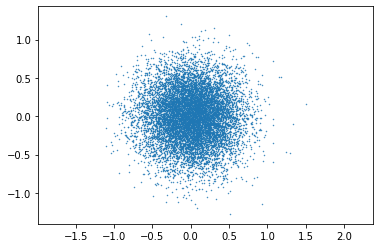

In [35]:
# This should look sufficiently like a multivariate gaussian
plt.scatter(sharp_likelihood_dataframe["x1"], sharp_likelihood_dataframe["x2"], s=.2)
plt.axis("equal")

In [36]:
# we can check the performance of the bandwidth finder
# by running the weigher with different bandwidths again a slightly larger
# bandwidth would be preferred because the likelihood is truly gaussian
divergences={}
for deltabw in [ -.1, -.05,.00, .05, .1, .2, .3,.4, .5]:
    test_weighed_samples = executables.weigh_samples(sharp_likelihood_dataframe, 
                                            prior_dataframe, output=None,
                                           bandwidth=sharp_bw + deltabw, 
                                            columns=["x1", "x2"],
                                           prior_columns=[], prior_name=None, 
                                            save_samples=False, reflect=False)
    # 
    # compute the KL divergence between the two distributions
    test_logp_kde =  test_weighed_samples["logweight"]- logsumexp(test_weighed_samples["logweight"])
    divergences[deltabw] = np.sum(rel_entr(np.exp(test_logp_kde), np.exp(logp_true)))

In [37]:
divergences

{-0.1: 0.1419633069428154,
 -0.05: 0.024625073182149015,
 0.0: 0.010300923383397416,
 0.05: 0.006261523043794968,
 0.1: 0.004998751656360605,
 0.2: 0.006884626961349639,
 0.3: 0.01533127511822031,
 0.4: 0.032523255699301985,
 0.5: 0.06091323943328283}

Text(0, 0.5, 'probability')

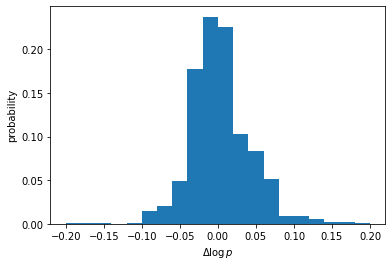

In [42]:
# We plot  Delta(logp) / sqrt(1+ abs log(p)) again
# Again, the errors are typically no worse than 1/10 the threshold
plt.hist((logp_kde - logp_true)/np.sqrt(1-logp_kde), bins=20, weights=np.exp(logp_kde), range=(-.2, .2))
plt.xlabel(r"$\Delta \log p$")
plt.ylabel("probability")

# Checking qualitative agreement of the KDE likelihood to the LVK samples

In [3]:
# Here we need to get Astro data and retrieve the bandwidth for the likelihood kde
astro_prefix = "/home/isaac.legred/lwp/Examples/LVC_GW170817_PhenomPNRT-lo"
# As before, these are the true 170817 likelihood samples
astro_data = pd.read_csv(f"{astro_prefix}.csv")



astro_input=pd.read_csv(f"{astro_prefix}.in")
bandwidth = astro_input["bw"][0]

In [4]:
# Sample a flat prior which encompasses the whole likelihood
seed = 12345
rng = np.random.default_rng(seed=seed) # random number generator
chirp_mass_samples = rng.uniform(1.18, 1.19, 100000)
mass_ratio_samples = rng.uniform(.4,1.0, 100000)
mass_1, mass_2 =  conversion.chirp_mass_and_mass_ratio_to_component_masses(chirp_mass_samples, mass_ratio_samples)
lambda_samples = rng.uniform(0, 2500, (100000,2))
luminosity_distance_samples = rng.uniform(20, 80, (20000,1))

In [5]:
# Turn the prior samples into a dataframe with the right column labels
prior_samples = pd.DataFrame(np.hstack([np.transpose(np.array([mass_1])), np.transpose(np.array([mass_2])), lambda_samples]), columns=["m1","m2","Lambda1","Lambda2"])

In [6]:
# Weigh the prior samples by the kde likelihood
weighed_samples = executables.weigh_samples(astro_data, prior_samples, output=None,prior_columns =["m1","m2", "luminosity_distance_Mpc"], columns=["m1","m2","Lambda1","Lambda2"],
                          bandwidth=bandwidth,save_samples=False, reflect="True")

In [133]:
# S
fair_samples  = weighed_samples.sample(n=
                                       3952, weights = np.exp(weighed_samples["logweight"]), replace=True,  ignore_index=True)
print(len(np.unique(fair_samples["m1"])))
fair_samples["astro"]=0
astro_data["astro"] =1

2984


In [1]:
# We plot the Astro and likelihood rejected samples,  the kde-sampled points have replacement
sns.pairplot(pd.concat(
    [fair_samples[["m1","m2","Lambda1","Lambda2","astro"]], 
     astro_data[["m1","m2","Lambda1","Lambda2", "astro"]] ], ignore_index=True) , corner=True, plot_kws={"s": 2.0}, kind="scatter", hue="astro")

NameError: name 'sns' is not defined

In [ ]:
executables.scan_likelihood(["LVC_GW170817_PhenomPNRT-lo.csv"], cols=["m1", "m2", "Lambda1", "Lambda2"])